# First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

# Final project: Finding the suspect

## Author: Max Pinheiro Jr

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

The final project is developed in a way that you can apply learned techniques to real project yourself. We will include the main guidelines and hints, but a great part of the project will need your creativity and experience from previous assignments.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
%tensorflow_version 2.x

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_final_project()

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2023-05-11 10:55:15--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.20K  --.-KB/s    in 0s      

2023-05-11 10:55:15 (76.4 MB/s) - ‘setup_google_colab.py’ saved [1232/1232]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week7_(final_project)/utils.py utils.py
https://github.com/hse-aml/bayesian-methods-for-ml/releases/download/v0.1/CelebA_VAE_small_8.h5 CelebA_VAE_small_

In [2]:
%%bash

rm -rf utils.py
wget https://raw.githubusercontent.com/maxjr82/bayesian-methods-for-ml/main/final_project/utils.py

--2023-05-11 10:56:00--  https://raw.githubusercontent.com/maxjr82/bayesian-methods-for-ml/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5103 (5.0K) [text/plain]
Saving to: ‘utils.py’

     0K ....                                                  100% 33.1M=0s

2023-05-11 10:56:00 (33.1 MB/s) - ‘utils.py’ saved [5103/5103]



In [3]:
! pip install GPy gpyopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3296982 sha256=bdf8c1f347d3c9817a4709f9a1a1240a8647b2e8d29b1cab2d9ea160b1d0789b
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83591 sha256=9d4cdea8033183a5bb8e3cfe6dae4a6b3aa8b96124fbbfc7971623e3f6767345
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created whe

In [4]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Import Gaussian Process libraries
import GPy
import GPyOpt
# Import Neural Network libraries
import keras
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose
from keras.losses import MSE
from keras.models import Model, Sequential
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils

tf.compat.v1.disable_eager_execution()

### Grading
As some of the final project tasks can be graded only visually, the final assignment is graded using the peer-review procedure. You will be asked to upload your Jupyter notebook on the web and attach a link to it in the submission form. Detailed submission instructions and grading criterions are written at the end of this notebook.

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task, you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of the final project if you wish to train VAE on your own.

<b>Task 1:</b> Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignments. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

In [5]:
sess = tf.compat.v1.InteractiveSession()
K.set_session(sess)

In [6]:
latent_size = 8

In [7]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
init = tf.compat.v1.global_variables_initializer()
sess.run(init)
vae.load_weights('CelebA_VAE_small_8.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
K.set_learning_phase(False)

In [9]:
# Generate new n_samples
n_samples = 25
latent_placeholder = tf.compat.v1.placeholder(tf.float32, (n_samples, latent_size))
decode = decoder(latent_placeholder)

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As the first part of the assignment, you need to become familiar with the trained model. For all tasks, you will only need a decoder to reconstruct samples from a latent space.

To decode the latent variable, you need to run ```decode``` operation defined above with random samples from a standard normal distribution.

In [10]:
# Generate 25 new samples from a normal distribution
rnd_norm = np.random.normal(size=(n_samples,latent_size))
img_sampled = sess.run(decode, 
                       feed_dict = {latent_placeholder : rnd_norm})
img_sampled.shape

(25, 64, 64, 3)

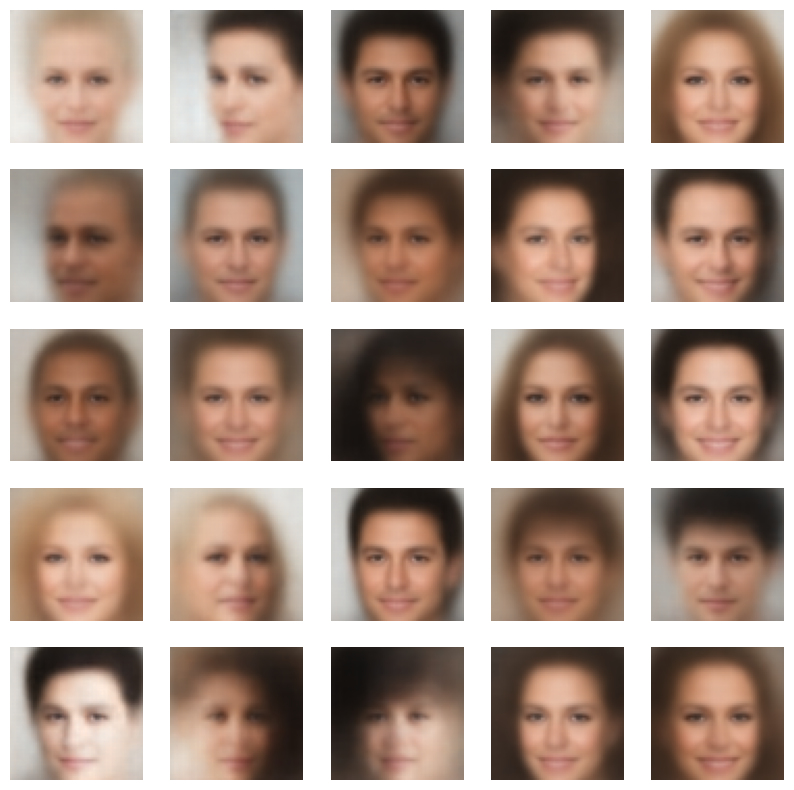

In [11]:
### TODO: Draw 25 samples from VAE here
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    image = img_sampled[i]
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying `acquisition_type` and `acquisition_par` parameters.

In [ ]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.latent_placeholder = None
        self.decode = None
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[None, :]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 4))
        n = len(titles)
        n_rows = 1
        for i in range(n):
            plt.subplot(n_rows, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start=10, select_top=5):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        # Generates latent code for the best images to keep
        self.samples = np.random.normal(size=(n_start, self.latent_size))
        self.latent_placeholder = tf.compat.v1.placeholder(tf.float32, 
                                                           (n_start, 
                                                           self.latent_size))
        self.decode = decoder(self.latent_placeholder)
        # Create new images by feeding the latent code into the decoder
        self.images = sess.run(
                          self.decode, 
                          feed_dict = {self.latent_placeholder: self.samples}
                              )
        
        while True:
          self.rating = []
          img_labels = []
          # Let's show an image at a time to avoid confusing the user
          for n, img in enumerate(self.images, 1):
            img = np.expand_dims(img, axis=0)
            self._show_images(img, [f"Sample face {n}"])
            img_rate = input('Please enter a rating for the face above: 0 (dissimilar) to 5 (similar)\n')
            img_labels.append(f"Face {n} | Score {img_rate}")
            self.rating.append(int(img_rate))
            del img_rate
          # Show all the labeled images for the user to decide if it is ok.
          self._show_images(self.images, img_labels)
          time.sleep(0.5)
          finish = input('Are you sure about your ratings? [yes or no]\n')
          finish = finish.lower().replace(" ", "")
          if finish == "yes":
            break

        self.rating = np.array(self.rating)
        # Keep only the select_top images with the highest ratings
        ind_top_score = self.rating.argsort()[-select_top:]
        self.rating = self.rating[ind_top_score]
        self.images = self.images[ind_top_score]
        self.samples = self.samples[ind_top_score]

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)
        
        ## Show user an image and ask to assign score to it.
        self.samples = np.vstack((self.samples, candidate))
        latent_placeholder = tf.compat.v1.placeholder(tf.float32, 
                                                           (1, self.latent_size))
        decode = decoder(latent_placeholder)
        # Generate new candidate image from latent code
        candidate = sess.run(decode, feed_dict = {latent_placeholder: candidate})
        # You should also save candidate, corresponding image and rating
        self.images = np.append(self.images, candidate, axis=0)

        titles =  [f"Score {r}" for r in self.rating] + ['New candidate']
        self._show_images(self.images, titles)
        time.sleep(0.7)
        candidate_rate = input('Please enter a rating for the new candidate:\n')
        candidate_rate = int(candidate_rate)
        self.rating = np.append(self.rating, candidate_rate)

        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rate

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title='', mean_top_rate=None):
        if mean_top_rate is not None:
           ind_top_score = self.rating.argsort()[-mean_top_rate:]
           top_rating = self.rating[ind_top_score]
           mean_sample = np.mean(self.samples[ind_top_score], 
                                 axis=0, keepdims=True)
           latent_placeholder = tf.compat.v1.placeholder(tf.float32, 
                                                           (1, self.latent_size))
           decode = decoder(latent_placeholder)
           image = sess.run(decode, feed_dict = {latent_placeholder: mean_sample})
           image = image[0]
        else:
          index_best = np.argmax(self.rating)
          image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

#### GRADED 2 (3 points):
Describe your approach below: How do you assign a score to a new image? How do you select reference images to help user assign a new score? What are the limitations of your approach?


*   As a first step for the score assignment, ten random images are generated by sampling points in the latent space. The number of initially generated images is defined by the `n_start` variable of the `query_initial` method.
*   Next, each of the `n_start` images is displayed to the user, who is requested to provide a score between 0 and 5 that reflects how similar or dissimilar the generated image is to a desired feature (such as "dark hair" or "mustache"). We show the images sequentially to avoid potential biases in the score assignment due to comparisons with other images. After scoring the ten images, the user will have the option of modifying the scores if he/she is not satisfied with the previous assignments. 
*   We store each score value provided by the user in the class variable `self.rating`. This variable is later filtered by keeping only the top five scores, which will be used to guide the GP bayesian optimization.



Although Variationa Autoencoders (VAEs) are powerful generative models for image generation and recognition tasks, there are several limitations to consider, especially when attempting to navigate the latent space to find images with specific features.

- VAE's latent space may not be expressive enough to fully represent all input features, making it challenging to find images with specific features in the latent space.
- Because the VAE's latent space is typically continuous and high-dimensional, it is usually hard to generate images with specific features in a controlled manner.
- Another limitation observed in the experiments with the combined VAE + GPOpt procedure is that the algorithm may become trapped in local optima regions of the latent space that do not correspond to the desired direction of improvement.
- Finally, since the score assignments by the user are subjective, it can be challenging to obtain consistent and accurate labels that guide the optimization process in the intended direction, especially when trying to assess the image's similarity to global features, such as finding a specific person. 

## Testing your algorithm

In these sections, we will apply the implemented app to search for different people. Each task will ask you to generate images that will have some property like "dark hair" or "mustache". You will need to run your search algorithm and provide the best discovered image.

#### Task 3.1: Finding person with darkest hair (3 points)

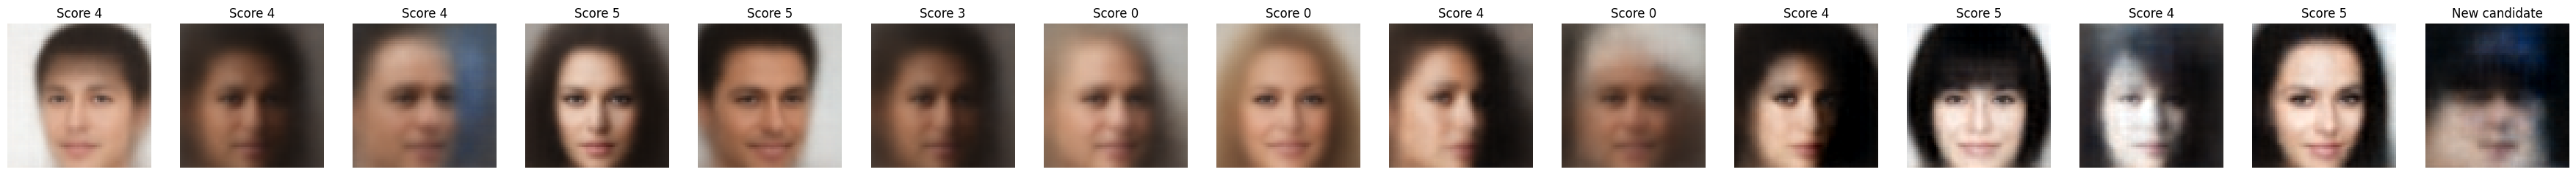

Please enter a rating for the new candidate:
0


In [25]:
composit = FacialComposit(decoder, 8)
composit.optimize()

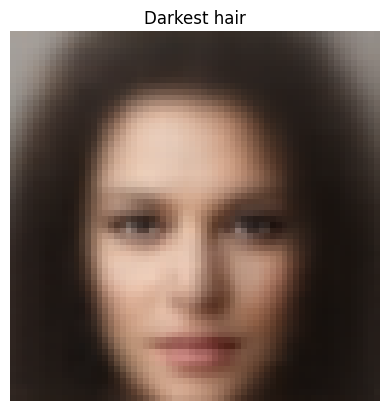

In [31]:
composit.draw_best('Darkest hair')

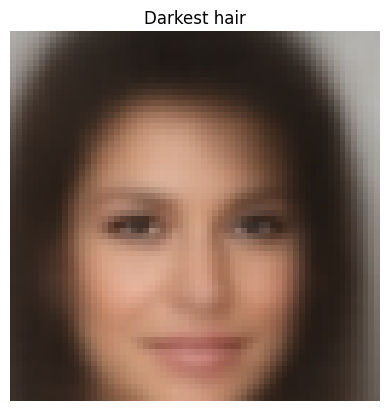

In [32]:
# Create new image by averaging the latent vectors over the top 5 rated images
composit.draw_best('Darkest hair', mean_top_rate=5)

#### Task 3.2. Finding person with the widest smile (3 points)

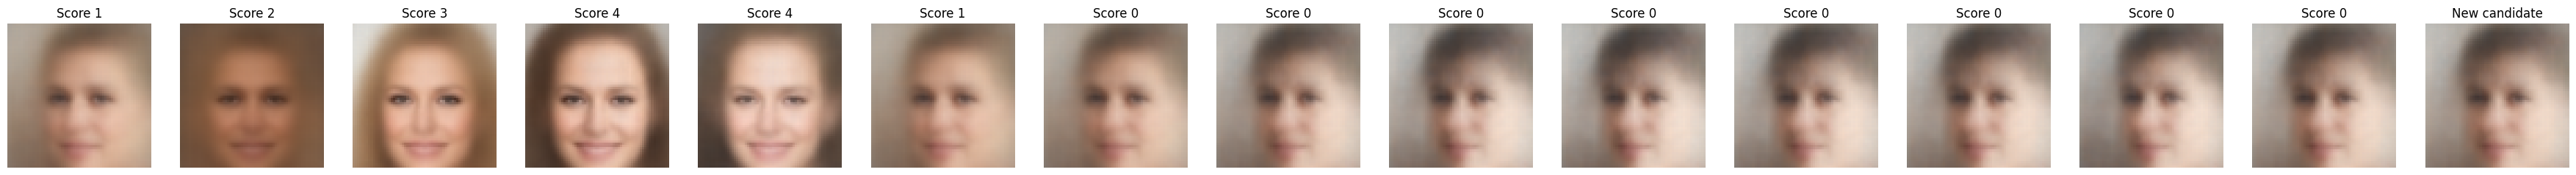

Please enter a rating for the new candidate:
0


In [35]:
composit = FacialComposit(decoder, 8)
composit.optimize()

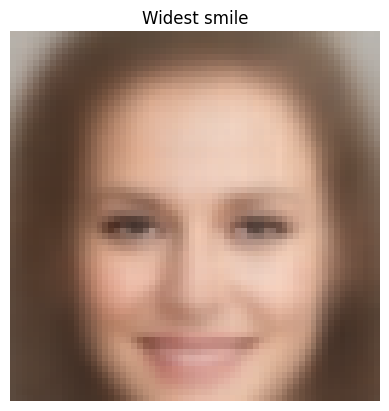

In [36]:
composit.draw_best('Widest smile')

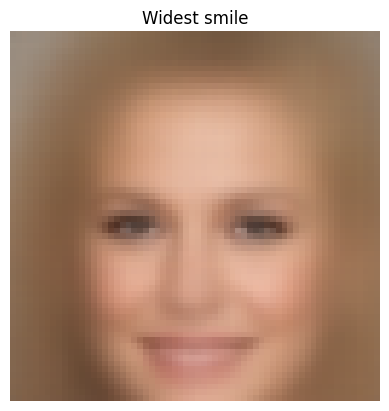

In [37]:
# Create new image by averaging the latent vectors over the top 5 rated images
composit.draw_best('Widest smile', mean_top_rate=5)

#### Task 3.3. Finding Daniil Polykovskiy or Alexander Novikov — lecturers of this course (3 points) 

Note: this task highly depends on the quality of a VAE and a search algorithm. You may need to restart your search algorithm a few times and start with larget initial set.

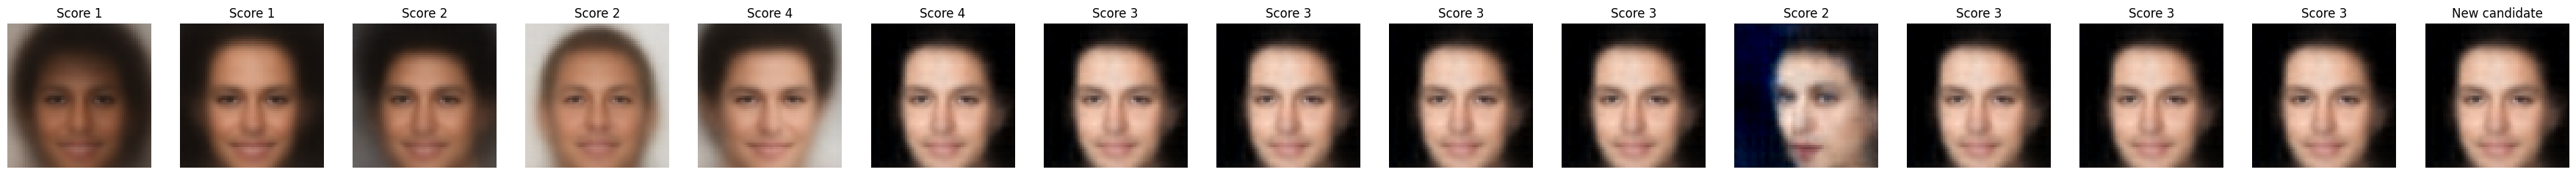

Please enter a rating for the new candidate:
3


In [57]:
composit = FacialComposit(decoder, 8)
composit.optimize(w=6, acquisition_par=0.5)

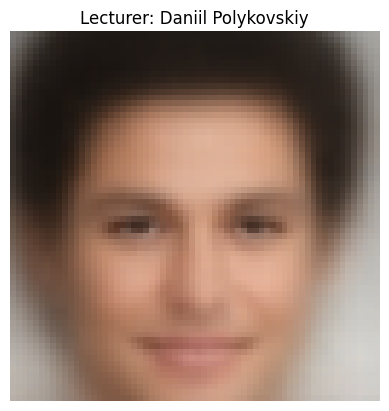

In [58]:
composit.draw_best('Lecturer: Daniil Polykovskiy')

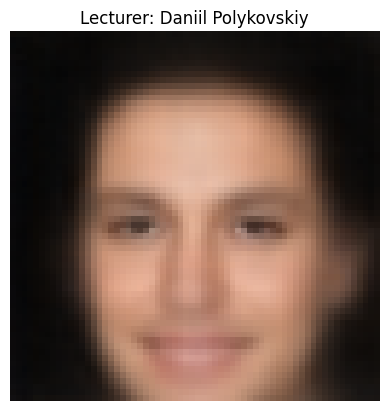

In [61]:
composit.draw_best('Lecturer: Daniil Polykovskiy', mean_top_rate=3)

#### <small>Don't forget to post resulting image of lecturers on the forum ;)</small>

#### Task 3.4. Finding specific person (optional, but very cool)

Now that you have a good sense of what your algorithm can do, here is an optional assignment for you. Think of a famous person and take look at his/her picture for a minute. Then use your app to create an image of the person you thought of. You can post it in the forum <a href="https://www.coursera.org/learn/bayesian-methods-in-machine-learning/discussions/forums/SE06u3rLEeeh0gq4yYKIVA">Final project: guess who!</a>


In [ ]:
### Your code here

### Submission
You need to share this notebook via a link: click `SHARE` (in the top-right corner) $\rightarrow$ `Get shareable link`, **then click `Change to anyone with the link`** (otherwise your peer reviewers want be able to access your work) and then paste the link into the assignment page.

**Note** that the reviewers always see the current version of the notebook, so please do not remove or change the contents of the notebook until the review is done.

##### If you are working locally (e.g. using Jupyter instead of Colab)
Please upload your notebook to Colab and share it via the link or upload the notebook to any file sharing service (e.g. Dropbox) and submit the link to the notebook through https://nbviewer.jupyter.org/, so by clicking on the link the reviewers will see it's contents (and will not need to download the file).

### Grading criterions

#### Task 1 (3 points) [samples from VAE]
* 0 points: No results were provided here or provided images were not generated by VAE
* 1 point: Provided images poorly resemble faces
* 2 points: Provided images look like faces, maybe with some artifacts, but all look the same
* 3 points: Provided images look like faces, maybe with some artifacts, and look different

#### Task 2 (3 points) [training procedure]
* 0 points: No result was provided
* 1 point: Some algorithm was proposed, but it does not use Bayesian optimization
* 2 points: Algorithm was proposed, but there were no details on some important aspects: how to assign a score to a new image / how to you select a new image / what are the limitations of the approach
* 3 points: Algorithm was proposed, all questions in the task were answered

#### Tasks 3.1-3.3 (3 points each) [search for person]
* 0 points: Nothing was provided
* 1 point: Resulting image was provided, but some of the required images (evolution & nearest image) are not provided
* 2 points: All images are provided, but the resulting image does not have requested property
* 3 points: All images are provided, the resulting image has required features (long hair / wide smile / looks like lecturer)

## Passing grade is 60% (9 points)